In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

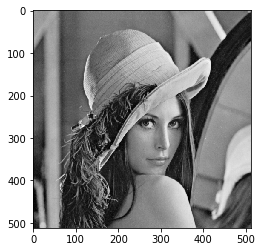

In [2]:
img = cv2.imread("./lena.bmp", 0)
plt.imshow(img, cmap="gray")
plt.show()

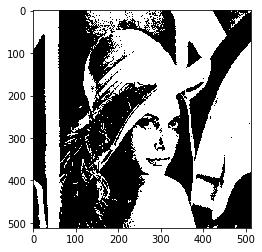

In [3]:
binaryImg = np.zeros((512, 512))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i][j] < 128:
            binaryImg[i][j] = 0;
        else:
            binaryImg[i][j] = 255;
plt.imshow(binaryImg, cmap="gray")
plt.show()

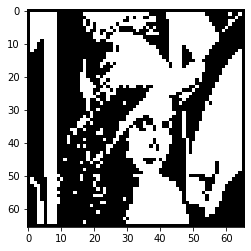

In [4]:
downSampleImg = np.zeros((66, 66))
for i in range(64):
    for j in range(64):
        downSampleImg[i+1][j+1] = binaryImg[i*8][j*8]
plt.imshow(downSampleImg, cmap="gray")
plt.show()

In [5]:
#https://slideplayer.com/slide/15387800/
def yokoi(downSampleImg):
    yokoiImg = np.zeros((66, 66))
    def h(b, c, d, e):
        if b == c and (d != b or e != b):
            return 'q'
        elif b == c and (d == b and e == b):
            return 'r'
        else:
            return 's'

    def f(a1, a2, a3, a4):
        if a1 == a2 == a3 == a4 == 'r':
            return 5
        else:
            count = 0
            if a1 == 'q':
                count += 1
            if a2 == 'q':
                count += 1
            if a3 == 'q':
                count += 1
            if a4 == 'q':
                count += 1
            return count

    for i in range(64): # 1~65
        for j in range(64):
            # center = i+1, j+1
            if downSampleImg[i+1][j+1] == 255:
                a1 = h(downSampleImg[i+1][j+1], downSampleImg[i+1][j+2], downSampleImg[i][j+2], downSampleImg[i][j+1])
                a2 = h(downSampleImg[i+1][j+1], downSampleImg[i][j+1], downSampleImg[i][j], downSampleImg[i+1][j])
                a3 = h(downSampleImg[i+1][j+1], downSampleImg[i+1][j], downSampleImg[i+2][j], downSampleImg[i+2][j+1])
                a4 = h(downSampleImg[i+1][j+1], downSampleImg[i+2][j+1], downSampleImg[i+2][j+2], downSampleImg[i+1][j+2])
                yokoiImg[i+1][j+1] = f(a1, a2, a3, a4)
    return yokoiImg

yokoiImg = yokoi(downSampleImg)
print(yokoiImg)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
#np.set_printoptions(threshold=sys.maxsize)
def markPQ(yokoiImg): # 66, 66
    pqImg = np.zeros((66, 66), dtype=np.int32) #p = 1, q = 2
    for i in range(64): # 1~65
        for j in range(64):
            if yokoiImg[i+1][j+1] == 0:
                continue
            if (yokoiImg[i][j+1] != 1 and yokoiImg[i+2][j+1] != 1 and yokoiImg[i+1][j] != 1 and yokoiImg[i+1][j+2] != 1) or yokoiImg[i+1][j+1] != 1:
                pqImg[i+1][j+1] = 2
            elif (yokoiImg[i][j+1] ==1 or yokoiImg[i+2][j+1] == 1 or yokoiImg[i+1][j] == 1 or yokoiImg[i+1][j+2] == 1) and yokoiImg[i+1][j+1] == 1:
                pqImg[i+1][j+1] = 1
    return pqImg
pqImg = markPQ(yokoiImg)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0. 255.   0.]
 [  0.   0. 255. ... 255.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


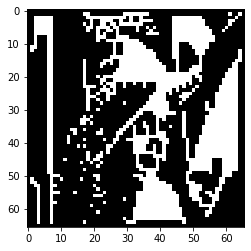

In [7]:
def shrink(pqImg, downSampleImg):
    shrinkImg = np.copy(downSampleImg)
    def h(b, c, d, e):
        if b == c and (d != b or e != b):
            return 1
        else:
            return 0

    def f(a1, a2, a3, a4):
        count = a1 + a2 + a3 + a4
        if count == 1:
            return 1
        return 0
    
    for i in range(64): # 1~65
        for j in range(64):
            # center = i+1, j+1
            if pqImg[i+1][j+1] == 1: #for every p
                a1 = h(shrinkImg[i+1][j+1], shrinkImg[i+1][j+2], shrinkImg[i][j+2], shrinkImg[i][j+1])
                a2 = h(shrinkImg[i+1][j+1], shrinkImg[i][j+1], shrinkImg[i][j], shrinkImg[i+1][j])
                a3 = h(shrinkImg[i+1][j+1], shrinkImg[i+1][j], shrinkImg[i+2][j], shrinkImg[i+2][j+1])
                a4 = h(shrinkImg[i+1][j+1], shrinkImg[i+2][j+1], shrinkImg[i+2][j+2], shrinkImg[i+1][j+2])
                #shrinkImg[i+1][j+1] = f(a1, a2, a3, a4)
                if f(a1, a2, a3, a4) == 1:
                    shrinkImg[i+1][j+1] = 0
                
    return shrinkImg
#np.set_printoptions(threshold=sys.maxsize)
shrinkImg = shrink(pqImg, downSampleImg)
print(shrinkImg)
plt.imshow(shrinkImg, cmap="gray")
plt.show()

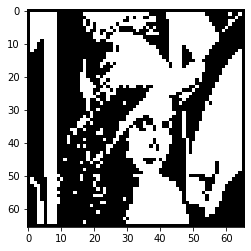

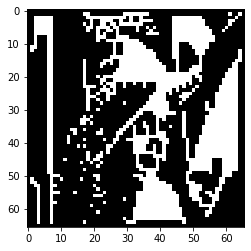

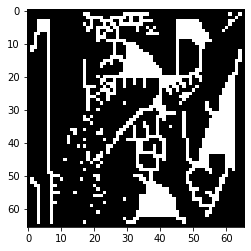

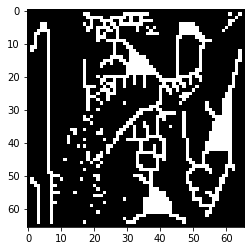

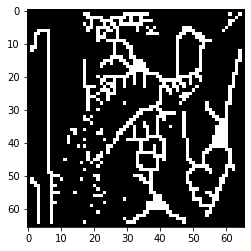

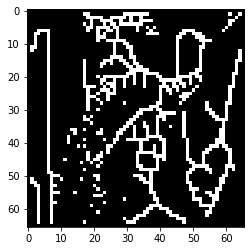

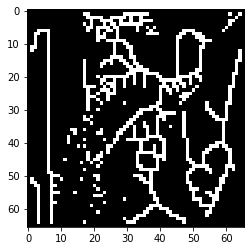

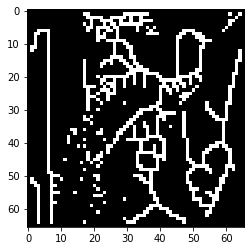

In [8]:
def thiningOP(downSampleImg):
    yokoiImg = yokoi(downSampleImg)
    pqImg = markPQ(yokoiImg)
    shrinkImg = shrink(pqImg, downSampleImg)
    return shrinkImg

tempImg = np.copy(downSampleImg)
plt.imshow(tempImg, cmap="gray")
plt.show()
for i in range(7):
    tempImg = thiningOP(tempImg)
    plt.imshow(tempImg, cmap="gray")
    plt.show()

In [58]:
tempImg2 = np.zeros((66, 66))
tempImg2[1][1] = 255
tempImg2[1][2] = 255
tempImg2[2][2] = 255
tempImg2[2][3] = 255
tempImg2[3][3] = 255
tempImg2[4][3] = 255
tempImg2[5][3] = 255
tempImg2[3][4] = 255
tempImg2[4][4] = 255
tempImg2[5][4] = 255
yokoiImg = yokoi(tempImg2)
#print(yokoiImg)
pqImg = markPQ(yokoiImg)
print(pqImg)
shrinkImg = shrink(pqImg, tempImg2)
print(shrinkImg)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0